In [82]:
import graphviz
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from docx import Document
from docx.shared import Inches

def plot_walk(path):
    f = graphviz.Digraph('walk')

    f.attr(rankdir='LR', size='8,5')

    f.attr('node', shape='doublecircle')
    f.node('1')

    f.attr('node', shape='circle')

    for n in set(path)-set([1]):
        f.node(str(n))

    for i in range(len(path)-1):
        f.edge(str(path[i]), str(path[i+1]), label=str(i+1))

    return f

In [32]:
def get_walks(steps):
    walks = [[1]]

    while steps > 0:
        new_walks = []
        for walk in walks:
            # returned too early
            if walk.count(1) > 1:
                continue

            # one walk going down
            if walk[-1] > 1:
                down_node = [walk[i-1] for i in range(1,len(walk)) if (walk[i]==walk[-1] and walk[i] > walk[i-1])]
                new_walks.append(walk + [down_node[0]])

            # go up through all previous ups
            previous_ups = set([walk[i+1] for i in range(len(walk)-1) if (walk[i]==walk[-1] and walk[i+1] > walk[i])])
            for up in previous_ups:
                new_walks.append(walk + [up])

            # go up through a new up
            new_up = max(walk)+1
            new_walks.append(walk + [new_up])

        steps -= 1
        walks = new_walks

    walks = [walk for walk in walks if walk[-1]==1 and walk.count(1)==2]
    return walks

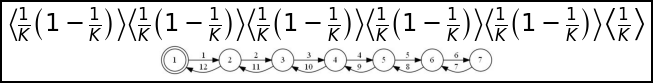

In [123]:
def get_corr(path):
    nodes = {}
    for node in set(path)-set([1]):
        nodes_visited_from_node = [path[j+1] for j in range(len(path)-1) if path[j]==node]
        up_nodes = [j for j in nodes_visited_from_node if j > node]
        down_nodes = [j for j in nodes_visited_from_node if j < node]

        unique_up_nodes = len(set(up_nodes))

        nodes[node] = {
            'factorial': unique_up_nodes,
            'simple': len(down_nodes)+len(up_nodes)-unique_up_nodes
        }

    return nodes


def corr_to_latex(corr):
    latex = ''
    for node, v in corr.items():
        latex += r'\left<'
        if v['simple'] > 1:
            latex += r'\frac{1}{K^{'+str(v['simple'])+'}}'
        else:
            latex += r'\frac{1}{K}'
        latex += ''.join([fr'\left(1-\frac{{{i}}}{{K}}\right)' for i in range(1,v['factorial']+1)])
        latex += r'\right>'

    return latex

document = Document()
sections = document.sections
margin = Inches(0.5)
for section in sections:
    section.top_margin = margin
    section.bottom_margin = margin
    section.left_margin = margin
    section.right_margin = margin


for i in range(12,14,2):
    document.add_heading(f'Walks of length {i}', 0)
    p = document.add_paragraph()
    r = p.add_run()
    walks = get_walks(i)
    for j, walk in enumerate(walks):
        f = plot_walk(walk)
        f.render(f'{(j+1):02}', f'walk_figures/{i}/', cleanup=True, format='jpeg', view=False)
        img = np.asarray(Image.open(f'./walk_figures/{i}/{(j+1):02}.jpeg'))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'${corr_to_latex(get_corr(walk))}$', fontsize=24)
        fig = plt.gcf()
        fig.patch.set_linewidth(4)
        fig.patch.set_edgecolor('black')
        plt.savefig(f'walk_figures/{i}/{(j+1):02}.jpeg', facecolor='white', bbox_inches='tight', pad_inches=0.2)
        r.add_picture(f'walk_figures/{i}/{(j+1):02}.jpeg', width=fig.get_size_inches()[0]*Inches(0.6))
    document.add_page_break()
document.save(r'D:\ac\amirim\outputs\170923\walks12.docx')

In [34]:
get_walks(6)

[[1, 2, 3, 2, 3, 2, 1], [1, 2, 3, 2, 4, 2, 1], [1, 2, 3, 4, 3, 2, 1]]

In [145]:
paths = get_walks(8)

def corr_to_lambda(corr):
    elements = []
    for node, v in corr.items():
        node_elements = []
        if v['simple'] > 1:
            node_elements.append(f'1/k**{str(v["simple"])}')
        else:
            node_elements.append(f'1/k')
        node_elements += [f'1-{i}/k' for i in range(1,v['factorial']+1)]

        elements.append('(' + ')*('.join(node_elements) + ')')

    return '-*-'.join(elements)


def corr_to_mathematica(corr):
    elements = []
    for node, v in corr.items():
        node_elements = []
        if v['simple'] > 1:
            node_elements.append(f'1/k^{str(v["simple"])}')
        else:
            node_elements.append(f'1/k')
        node_elements += [f'1-{i}/k' for i in range(1,v['factorial']+1)]

        f = '(' + ')*('.join(node_elements) + ')'
        p = 'k/c*E^-c*c^k/k!'
        elements.append(f'FullSimplify[Sum[{f}*{p},{{k,1,Infinity}}],Assumptions -> c \[Element] Reals && 0 < c < 1]')

    return '*'.join(elements)

for path in paths:
    print(get_corr(path))
    print(corr_to_mathematica(get_corr(path)))

print('MySimplify['+'+'.join([corr_to_mathematica(get_corr(path)) for path in paths])+', rules]')

{2: {'factorial': 1, 'simple': 3}, 3: {'factorial': 0, 'simple': 3}}
FullSimplify[Sum[(1/k^3)*(1-1/k)*k/c*E^-c*c^k/k!,{k,1,Infinity}],Assumptions -> c \[Element] Reals && 0 < c < 1]*FullSimplify[Sum[(1/k^3)*k/c*E^-c*c^k/k!,{k,1,Infinity}],Assumptions -> c \[Element] Reals && 0 < c < 1]
{2: {'factorial': 2, 'simple': 2}, 3: {'factorial': 0, 'simple': 2}, 4: {'factorial': 0, 'simple': 1}}
FullSimplify[Sum[(1/k^2)*(1-1/k)*(1-2/k)*k/c*E^-c*c^k/k!,{k,1,Infinity}],Assumptions -> c \[Element] Reals && 0 < c < 1]*FullSimplify[Sum[(1/k^2)*k/c*E^-c*c^k/k!,{k,1,Infinity}],Assumptions -> c \[Element] Reals && 0 < c < 1]*FullSimplify[Sum[(1/k)*k/c*E^-c*c^k/k!,{k,1,Infinity}],Assumptions -> c \[Element] Reals && 0 < c < 1]
{2: {'factorial': 1, 'simple': 2}, 3: {'factorial': 1, 'simple': 2}, 4: {'factorial': 0, 'simple': 1}}
FullSimplify[Sum[(1/k^2)*(1-1/k)*k/c*E^-c*c^k/k!,{k,1,Infinity}],Assumptions -> c \[Element] Reals && 0 < c < 1]*FullSimplify[Sum[(1/k^2)*(1-1/k)*k/c*E^-c*c^k/k!,{k,1,Infinity}],

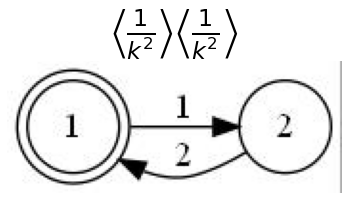

In [61]:


img = np.asarray(Image.open('./walk_figures/2/01.jpeg'))
imgplot = plt.imshow(img)
plt.axis('off')
plt.title(r'$\left<\frac{1}{k^{2}}\right>\left<\frac{1}{k^{2}}\right>$', fontsize=34)
plt.savefig('walk_figures/2/01.png', facecolor='white', bbox_inches='tight', pad_inches=0)

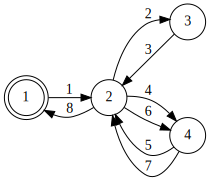

In [72]:
plot_walk(walks[0]) # E
plot_walk(walks[1]) # E' 1
plot_walk(walks[2]) # D
plot_walk(walks[3]) # E' 2
plot_walk(walks[4]) # E' 3
plot_walk(walks[5]) # E''
plot_walk(walks[6]) # D'
plot_walk(walks[7]) # C
plot_walk(walks[8]) # C'
plot_walk(walks[9]) # B
plot_walk(walks[10]) # B'
plot_walk(walks[11]) # A
plot_walk(walks[4])

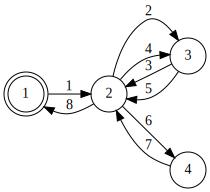

In [73]:
plot_walk(walks[1])